**1. DATASET**

In [ ]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv -O /databricks/driver/wikipedia.csv

import pandas as pd
dataset = pd.read_csv('/databricks/driver/wikipedia.csv')

spark_df = spark.createDataFrame(dataset)
spark_df = spark_df.drop("Unnamed: 0")

spark_df.write.format("delta").mode("overwrite").saveAsTable("wikipedia")

--2025-08-25 19:01:13--  https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.155.90, 52.95.155.94
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.155.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1003477941 (957M) [text/csv]
Saving to: ‘/databricks/driver/wikipedia.csv’

/databricks/driver/ 100%[===================>] 956.99M  21.0MB/s    in 1m 51s  

2025-08-25 19:03:04 (8.62 MB/s) - ‘/databricks/driver/wikipedia.csv’ saved [1003477941/1003477941]



**2. LIBRARIES**

In [ ]:
import warnings
warnings.filterwarnings('ignore')


!python -m pip install --upgrade pip --quiet


!pip install wordcloud --quiet
!pip install nltk --quiet
!pip install imblearn --quiet

In [ ]:
%pip install --upgrade pillow wordcloud -q

Python interpreter will be restarted.
Python interpreter will be restarted.


In [ ]:
import pandas as pd
from pyspark.sql.functions import col, when, count, countDistinct, pandas_udf
from pyspark.sql import functions as F
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from wordcloud import WordCloud
from pyspark.sql.functions import pandas_udf
import nltk
from nltk.stem import WordNetLemmatizer
from pyspark.sql.types import ArrayType, StringType, DoubleType
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import io
import sys
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Out[2]: True

In [ ]:
dataset = pd.read_csv('https://proai-datasets.s3.eu-west-3.amazonaws.com/wikipedia.csv')
df = spark.createDataFrame(dataset)
df = df.drop('Unnamed: 0').withColumnRenamed('categoria', 'category')
df.write.option("mergeSchema", "true").mode("overwrite").saveAsTable('wikipedia')

print(df.printSchema())
display(df.limit(5))

root
 |-- title: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- documents: string (nullable = true)
 |-- category: string (nullable = true)

None


title summary documents category economics economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. economics () is a social science that studies the production, distribution, and consumption of goods and services.economics focuses on the behaviour and interactions of economic agents and how economies work. microeconomics analyzes what's viewed as basic elements in the economy, including individual agents and markets, their interactions, and the outcomes of interactions. individual agents may include, for example, households, firms, buyers, and sellers. macroeconomics analyzes the economy as a system where production, consumption, saving, and investment interact, and factors affecting it: employment of the resources of labour, capital, and land, currency inflation, economic growth, and public policies that have impact on these elements. other broad distinctions within economics include those between positive economics, describing "what is", and normative economics, advocating "what ought to be"; between economic theory and applied economics; between rational and behavioural economics; and between mainstream economics and heterodox economics.economic analysis can be applied throughout society, including business, finance, cybersecurity, health care, engineering and government. it is also applied to such diverse subjects as crime, education, the family, feminism, law, philosophy, politics, religion, social institutions, war, science, and the environment. definitions of economics over time the earlier term for the discipline was 'political economy', but since the late 19th century, it has commonly been called 'economics'. the term is ultimately derived from ancient greek οἰκονομία (oikonomia) which is a term for the "way (nomos) to run a household (oikos)", or in other words the know-how of an οἰκονομικός (oikonomikos), or "household or homestead manager". derived terms such as "economy" can therefore often mean "frugal" or "thrifty". by extension then, "political economy" was the way to manage a polis or state. there are a variety of modern definitions of economics; some reflect evolving views of the subject or different views among economists. scottish philosopher adam smith (1776) defined what was then called political economy as "an inquiry into the nature and causes of the wealth of nations", in particular as: a branch of the science of a statesman or legislator [with the twofold objectives of providing] a plentiful revenue or subsistence for the people ... [and] to supply the state or commonwealth with a revenue for the publick services. jean-baptiste say (1803), distinguishing the subject matter from its public-policy uses, defi

In [ ]:
num_rows = df.count()
num_columns = len(df.columns)

print(f'Number of rows: {num_rows}, Number of columns: {num_columns}')

Number of rows: 153232, Number of columns: 4


The dataset consists of 153232 samples with 4 columns

In [ ]:
null_counts = df.select([count(when(col(c).isNull(), 1)).alias(c) for c in df.columns])

display(null_counts)

title summary documents category 0 928 928 0

The title and category columns have no missing values while summary and documents have 928 null elements.

In [ ]:
rows_with_nulls = df.filter(reduce(lambda a, b: a | b, (col(c).isNull() for c in df.columns)))

display(rows_with_nulls.limit(5))

title summary documents category file:sri kalamandalam padmanabhan nair.jpg null null culture talk:daughters of the polo god null null culture talk:imphal railway station null null culture talk:jiribam assembly constituency null null culture talk:manipur bush rat null null culture

In [ ]:
df = df.filter(~reduce(lambda a, b: a | b, (col(c).isNull() for c in df.columns)))

print(f'Number of rows: {df.count()}')

Number of rows: 152304


By eliminating null elements the number of samples in the dataset was reduced to 152304

In [ ]:
duplicates = df.groupBy('summary', 'documents', 'category').count().filter('count > 1')
total_duplicates = duplicates.agg({'count': 'sum'}).collect()[0][0] - duplicates.count()

display(duplicates.limit(5))
print(f'Number of samples with duplicates: {duplicates.count()}')
print(f'Total duplicates (excluding the original rows): {total_duplicates}')

summary documents category count kevin lane keller (born june 23, 1956) is the e. b. osborn professor of marketing at the tuck school of business at dartmouth college. he is most notable for having authored strategic brand management (prentice hall, 1998, 2002, 2008 and 2012), a widely used text on brand management. the book is focused on the "how to" and "why" of brand management, this strategy guide provides specific tactical guidelines for planning, building, measuring, and managing brand equity. he has published his research in the journal of marketing, journal of marketing research, and journal of consumer research. in addition, philip kotler selected keller to be his co-author on the most recent edition of kotler's market-leading text marketing management. keller was formerly on the faculty at the stanford graduate school of business, the university of california, berkeley and the university of north carolina at chapel hill. he has served as a visiting professor at duke university and the australian graduate school of management. he is an alumnus of cornell university, carnegie-mellon university and duke university. in the private sector, keller often acts as a consultant on branding, speaks at industry conferences, and helps to manage the rock band the church. keller currently resides in etna, new hampshire. kevin lane keller (born june 23, 1956) is the e. b. osborn professor of marketing at the tuck school of business at dartmouth college. he is most notable for having authored strategic brand management (prentice hall, 1998, 2002, 2008 and 2012), a widely used text on brand management. the book is focused on the "how to" and "why" of brand management, this strategy guide provides specific tactical guidelines for planning, building, measuring, and managing brand equity. he has published his research in the journal of marketing, journal of marketing research, and journal of consumer research. in addition, philip kotler selected keller to be his co-author on the most recent edition of kotler's market-leading text marketing management. keller was formerly on the faculty at the stanford graduate school of business, the university of california, berkeley and the university of north carolina at chapel hill. he has served as a visiting professor at duke university and the australian graduate school of management. he is an alumnus of cornell university, carnegie-mellon university and duke university. in the private sector, keller often acts as a consultant on branding, speaks at industry conferences, and helps to manage the rock band the church. keller currently resides in etna, new hampshire. books kotler, philip/keller, kevin lane: marketing management, 13th edition, upper saddle river, nj: prentice-hall, 2009, isbn 978-0131457577 keller, kevin lane and swaminathan, vanitha 2020. "strategic brand management", 5th edition, pearson isbn 978-1292314969 keller, kevin lane: best practice cases in branding, 3rd ed., upper saddle river, nj: prentice-hall, 2008, isbn 978-0131888654 references kevin lane keller, e. b. osborn professor of marketing. dartmouth college. accessed february 24, 2011. economics 2 guy benveniste (february 27, 1927 - december 3. 2022) was an organization theorist who has written about the politics of planning and ways of encouraging bureaucracies to be more adaptive to change. guy benveniste (february 27, 1927 - december 3. 2022) was an organization theorist who has written about the politics of planning and ways of encouraging bureaucracies to be more adaptive to change. early life benveniste was born in paris, france, on february 27, 1927. he left vichy france in may 1942 to take refuge in mexico. he attended harvard university, where he received a bs and ms in engineering in 1948 and 1950. he worked as a construction engineer and an economist for the mexican light and power company before emigrating to the united states in 1954. he then joined the stanford research institute in menlo park, california, wher

Number of samples with duplicates: 27082
Total duplicates (excluding the original rows): 77730


There are 27,082 samples with multiple duplicates. These are deleted.

In [ ]:
df = df.dropDuplicates(['summary', 'documents', 'category'])

print(f'Number of unique samples: {df.count()}')

Number of unique samples: 74574


In [ ]:
duplicates_text = df.groupBy('summary', 'documents').count().filter('count > 1')
total_duplicates_text = duplicates_text.agg({'count': 'sum'}).collect()[0][0] - duplicates_text.count()

display(duplicates_text.limit(5))
print(f'Number of samples with same text and different category: {duplicates_text.count()}')
print(f'Total duplicates with same text and different category (excluding the original rows): {total_duplicates_text}')

summary documents count nancy m. bonini (born 1959) is an american neuroscientist and geneticist, best known for pioneering the use of drosophila as a model organism to study neurodegeneration of the human brain. using the drosophila model approach, bonini's laboratory has identified genes and pathways that are important in the development and progression of neurodegenerative diseases such as amyotrophic lateral sclerosis (als, also called lou gehrig's disease), alzheimer's disease, and parkinson's disease, as well as aging, neural injury and regeneration, and response to environmental toxins.a professor of biology at the university of pennsylvania since 1994, bonini has held appointments as the inaugural lucille b. williams term professor of biology (2006–2012), an investigator of the howard hughes medical institute (2000–2013), and the florence rc murray professor of biology (since 2012). she was editor of the annual review of genetics from 2018-2021. nancy m. bonini (born 1959) is an american neuroscientist and geneticist, best known for pioneering the use of drosophila as a model organism to study neurodegeneration of the human brain. using the drosophila model approach, bonini's laboratory has identified genes and pathways that are important in the development and progression of neurodegenerative diseases such as amyotrophic lateral sclerosis (als, also called lou gehrig's disease), alzheimer's disease, and parkinson's disease, as well as aging, neural injury and regeneration, and response to environmental toxins.a professor of biology at the university of pennsylvania since 1994, bonini has held appointments as the inaugural lucille b. williams term professor of biology (2006–2012), an investigator of the howard hughes medical institute (2000–2013), and the florence rc murray professor of biology (since 2012). she was editor of the annual review of genetics from 2018-2021. early life and education bonini was born in 1959 to parents rose and william “bill” bonini. her father was a professor of geoscience and civil engineering at princeton university from 1952 to 1996. nancy, her sister (jennifer), brothers (jack and jamie), and father all attended princeton university.bonini earned an ab degree from princeton university in 1981, studying biology. her undergraduate thesis research, performed under the direction of william (chip) quinn, formed the basis for her first publication, "reward learning in normal and mutant drosophila". after graduation, bonini entered the neurosciences training program at the university of wisconsin–madison. there, she completed doctoral research in the laboratory of david l. nelson, graduating with a doctorate (ph.d.) in neuroscience in 1987. bonini's post-doctoral research was performed in the laboratory of seymour benzer (behavioral geneticist) at the california institute of technology. focusing on using the fruit fly as a tool for understanding the genetic basis of the brain and behavior, bonini was the first to demonstrate that drosophila can be used as a model of human neurodegenerative disease. research the fruit fly as a model for human neurodegenerative disease in 1998, bonini's research conclusively demonstrated that drosophila could be used as an in vivo model for human neurodegenerative disease. using this model, bonini's research group subsequently discovered unexpected and novel pathways that play a role in normal biology, injury, and disease. in the pioneering study that showed that the fruit fly can be used as a model of disease, bonini's laboratory collaborated with human geneticists to examine the effects of expressing normal and mutant forms of a human neurodegenerative polyq disease protein. flies that expressed the mutant form of the protein showed symptoms and characteristics similar to those seen in human polyq disease patients; flies that expressed the normal protein did not. chaperones and polyglutamine repeat diseases studying polyglutamine repeat diseases (polyq disease

Number of samples with same text and different category: 1192
Total duplicates with same text and different category (excluding the original rows): 1204


In [ ]:
conflicts_documents_summary = (df.groupBy("documents")
      .agg(countDistinct("summary").alias("distinct_summaries"))
      .filter(col("distinct_summaries") > 1)
      .withColumnRenamed("documents", "conflicted_documents"))

conflicts_summary_documents = (df.groupBy("summary")
      .agg(countDistinct("documents").alias("distinct_documents"))
      .filter(col("distinct_documents") > 1)
      .withColumnRenamed("summary", "conflicted_summaries"))

print("Conflicts: same documents, different summaries")
display(conflicts_documents_summary)
print("Conflicts: same summary, different documents")
display(conflicts_summary_documents)

Conflicts: same documents, different summaries


conflicted_documents distinct_summaries

Conflicts: same summary, different documents


conflicted_summaries distinct_documents the 1996 us open was a tennis tournament played on outdoor hard courts at the usta national tennis center in new york city in new york in the united states. it was the 116th edition of the us open and was held from august 26 through september 8, 1996. 2 the smithfield, smithfield collie or smithfield sheepdog is a breed of herding dog. it is a large, strong dog of the collie type. the smithfield can be black, grey or red with a white collar, or wholly white and they always possess floppy ears and shaggy hair on the body, face and legs. two varieties exist, with one having a natural bobtail and the second with a longer tail. it was used for droving cattle in the southeast of england, especially the smithfield market in london, and although this breed of dog is believed to be extinct and was never recognised by any of the major kennel clubs before its extinction, dogs of a similar type are shown under the same name in tasmania, australia. 2 the empire polo club is a 78-acre (32 ha) polo club in indio, california in the coachella valley of riverside county, approximately 22 miles southeast of palm springs. founded in 1987, it has hosted international polo tournaments. it leases out its polo grounds for coachella valley music and arts festival and stagecoach festival annually for the last three weekends in april. 2 the trinity court building was a building in lower manhattan, new york city. 2 the 1994 us open was a tennis tournament played on outdoor hard courts at the usta national tennis center in new york city in new york in the united states. it was the 114th edition of the us open and was held from august 29 to september 11, 1994. 2 players and pairs who neither have high enough rankings nor receive wild cards may participate in a qualifying tournament held one week before the annual us open. 2 science and technology studies (sts) or science, technology, and society is an interdisciplinary field that examines the creation, development, and consequences of science and technology in their historical, cultural, and social contexts. 2 the 1998 mercedes-benz cup was a men's tennis tournament played on hardcourt in los angeles, united states that was part of the international series of the 1998 atp tour. it was the seventy-first edition of the tournament and was held from july 27 through august 2, 1998. 2 on december 16, 1960, a united airlines douglas dc-8 bound for idlewild airport (now john f. kennedy international airport) in new york city collided in midair with a twa lockheed l-1049 super constellation descending toward laguardia airport. the constellation crashed on miller field in staten island and the dc-8 in park slope, brooklyn, killing all 128 aboard the two aircraft and six people on the ground. the accident was the world's deadliest aviation disaster at the time, and remains the deadliest accident in the history of united airlines. the accident became known as the park slope plane crash or the miller field crash after the two crash sites. the accident was also the first hull loss and first fatal accident involving a douglas dc-8. 2 shrek the third (also known as shrek 3) is a 2007 american computer-animated comedy film loosely based on the 1990 children's picture book shrek! by william steig. directed by chris miller (in his feature directorial debut) and co-directed by raman hui from a screenplay by jeffrey price, peter s. seaman, miller, and aron warner, the film is set after the events of shrek 2 (2004) and is the third installment in the shrek film series. the film features mike myers, eddie murphy, cameron diaz, antonio banderas, rupert everett, julie andrews, and john cleese reprising their voice roles from the previous films, along with new additions justin timberlake as arthur pendragon and eric idle as merlin. in the film, prince charming is plotting to overthrow shrek and fiona, who have inherited the throne following king harold's death. shrek has no interest in rulin

After performing the null value removal operations, we ended up with a dataset of 74,574 samples.

**3. ANALYSIS**

In [ ]:
categories = df.select('category').distinct()
display(categories)

category economics politics culture science sports energy finance humanities pets trade technology transport medicine engineering research

The Categories are 15: Economics, Politics, Culture, Science, Sports, Energy, Finance, Humanities, Pets, Trade, Technology, Transport, Medicine, Engineering and Research.

In [ ]:
category_counts = df.groupBy('category').count().orderBy('count', ascending=False)
category_percentages = category_counts['count']*100/df.count()
category_counts_perc = category_counts.withColumn('percentage',
                                                  F.round(category_percentages, 2))
display(category_counts_perc)

category count percentage medicine 8281 11.1 transport 7904 10.6 research 7571 10.15 technology 6669 8.94 engineering 6087 8.16 humanities 5794 7.77 finance 5328 7.14 pets 4610 6.18 energy 4552 6.1 economics 4259 5.71 trade 3853 5.17 science 3648 4.89 sports 3624 4.86 culture 2151 2.88 politics 243 0.33

The category with the most entries is Medicine with 8281 entries.

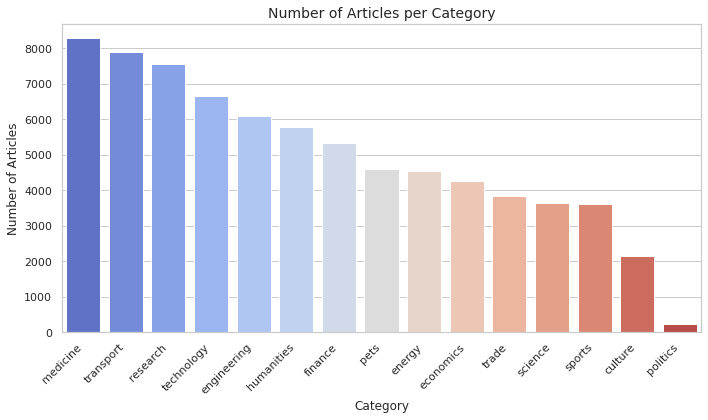

In [ ]:
category_counts_pd = category_counts.toPandas().sort_values(by='count', ascending=False)

sns.set_theme(style='whitegrid')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='category',
                 y='count',
                 data=category_counts_pd,
                 palette='coolwarm')

ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Number of Articles', fontsize=12)
ax.set_title('Number of Articles per Category', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

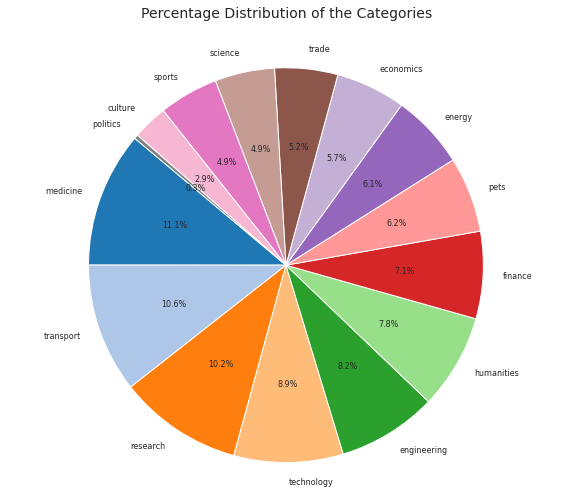

In [ ]:
rows = category_counts.collect()
labels = [r["category"] for r in rows]
sizes  = [r["count"]    for r in rows]

import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = cm.get_cmap('tab20')

plt.figure(figsize=(10,8))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors(range(len(sizes))),
    textprops={'fontsize': 8}
)
plt.title("Percentage Distribution of the Categories", fontsize=14, pad=30)
plt.axis("equal")
plt.show()

In [ ]:
cleaned_doc = F.regexp_replace(df['documents'], r'[^a-zA-Z0-9\s]', '')
average_words = df.select(F.avg(F.size(F.split(cleaned_doc, ' ')))).collect()[0][0]

print(f'Average number of words per article: {average_words:.2f}')

Average number of words per article: 794.10


In [ ]:
df_with_length = df.withColumn('word_count', F.size(F.split(cleaned_doc, ' ')))

length_stats = df_with_length.groupBy('category').agg(
        F.max('word_count').alias('max_length'),
        F.min('word_count').alias('min_length'))

display(length_stats)

category max_length min_length economics 24022 10 politics 20140 11 culture 15538 11 science 29419 15 sports 19227 14 energy 23223 9 finance 33479 3 humanities 23198 7 pets 13222 12 trade 19275 16 technology 18144 2 transport 22150 10 medicine 18422 12 engineering 11856 8 research 27223 17

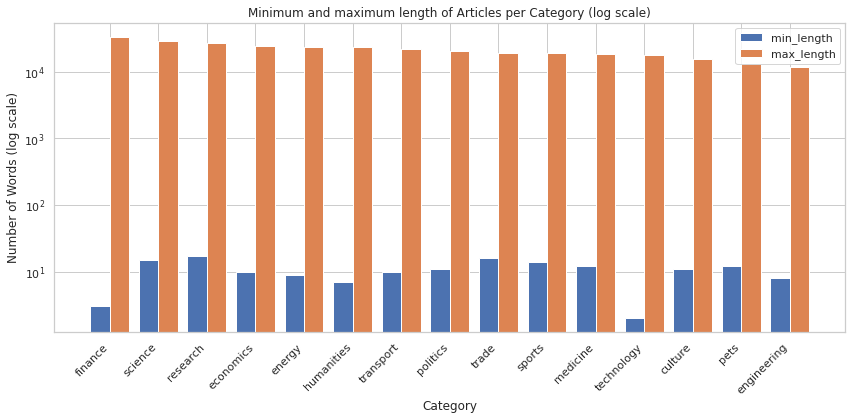

In [ ]:
rows = (length_stats.orderBy(F.desc("max_length")).limit(15)).collect()
cats = [r["category"] for r in rows]
maxs = [max(1, r["max_length"]) for r in rows]
mins = [max(1, r["min_length"]) for r in rows]

import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(cats))
w = 0.4

plt.figure(figsize=(12,6))
plt.bar(x - w/2, mins, width=w, label="min_length")
plt.bar(x + w/2, maxs, width=w, label="max_length")
plt.yscale("log")
plt.xticks(x, cats, rotation=45, ha="right")
plt.title("Minimum and maximum length of Articles per Category (log scale)")
plt.ylabel("Number of Words (log scale)")
plt.xlabel("Category")
plt.legend()
plt.tight_layout()
plt.show()

The longest element is contained within the Finance category while the shortest element is within the Technology category.

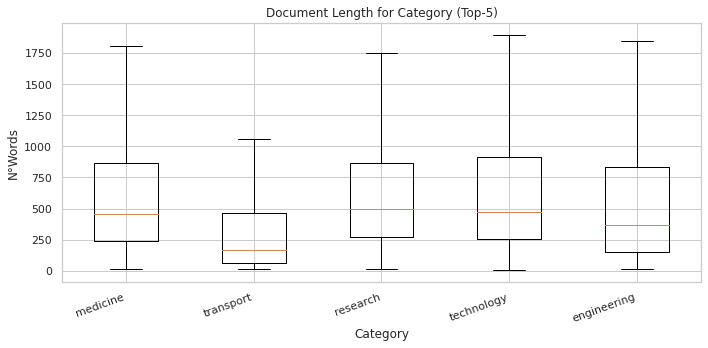

In [ ]:
TEXT_COL = "documents"

df_len_cat = (df
  .select("category",
          F.regexp_replace(F.lower(F.col(TEXT_COL)), r"[^a-zàèéìòóù0-9 ]", " ").alias("clean"))
  .withColumn("len_tokens", F.size(F.split(F.col("clean"), r"\s+")))
  .select("category","len_tokens")
  .filter(F.col("len_tokens").isNotNull())
)

top5 = [r["category"] for r in (df.groupBy("category").count()
                                  .orderBy(F.desc("count"))
                                  .limit(5)
                                  .collect())]

data = []
for c in top5:
    arr = [max(1, int(r["len_tokens"]))
           for r in (df_len_cat
                        .filter(F.col("category")==c)
                        .sample(False, 0.3, seed=42)
                        .limit(8000)
                        .select("len_tokens")
                        .toLocalIterator())]
    data.append(arr)

plt.figure(figsize=(10,5))
plt.boxplot(data, labels=top5, showfliers=False)
plt.title("Document Length for Category (Top-5)")
plt.xlabel("Category")
plt.ylabel("N°Words")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


Categoria: finance
company: 33881
: 29375
new: 21914
million: 14137
announced: 9337
time: 9142
business: 9129
united: 8957
two: 8950
series: 8886
building: 8840
us: 8604
york: 8487
acquired: 8247
film: 8141
street: 8139
states: 7889
american: 7551
billion: 7302
bank: 7152

Categoria: medicine
hospital: 37673
: 30982
health: 22859
university: 21888
medical: 21370
new: 17941
research: 17298
medicine: 16582
american: 12351
school: 11503
national: 10602
center: 9391
care: 9200
references: 8102
institute: 8031
college: 7929
public: 7556
award: 7421
work: 6937
two: 6825

Categoria: research
research: 35581
university: 28232
: 24876
medical: 17818
health: 15237
institute: 12747
medicine: 12739
national: 10979
new: 10575
professor: 10233
science: 10018
school: 9758
american: 9326
award: 8842
cancer: 8690
work: 8262
society: 7521
references: 7452
brain: 7275
college: 7263

Categoria: technology
game: 30954
: 22255
released: 13948
new: 12756
games: 12381
version: 11747
android: 11633
software: 

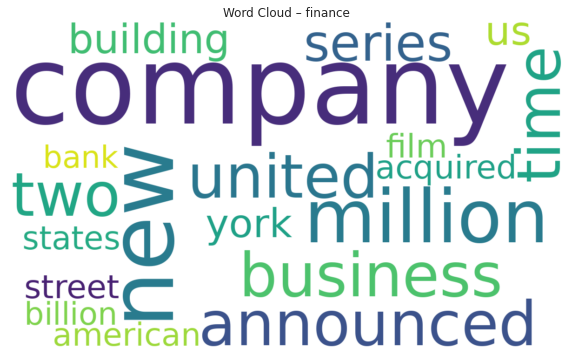

  Saved: /dbfs/FileStore/wordclouds/wordcloud_finance.png


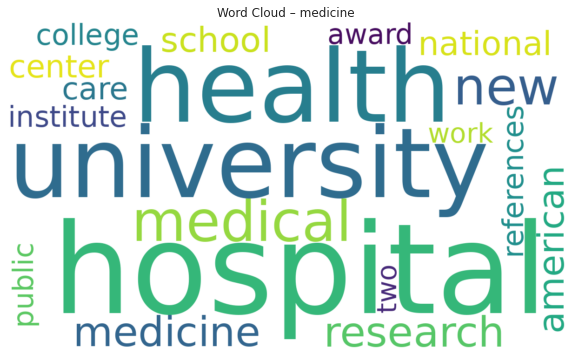

  Saved: /dbfs/FileStore/wordclouds/wordcloud_medicine.png


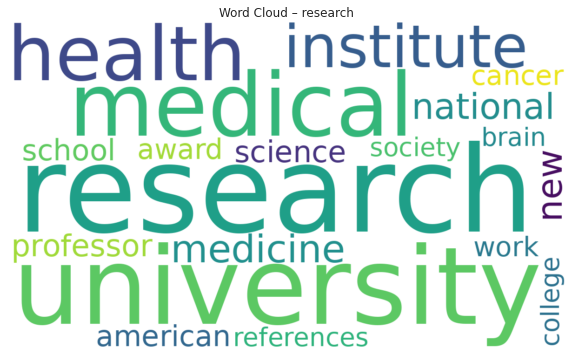

  Saved: /dbfs/FileStore/wordclouds/wordcloud_research.png


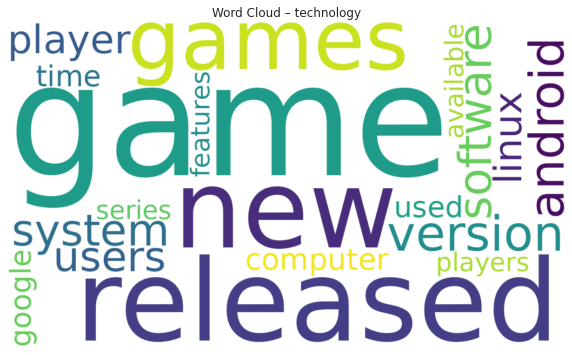

  Saved: /dbfs/FileStore/wordclouds/wordcloud_technology.png


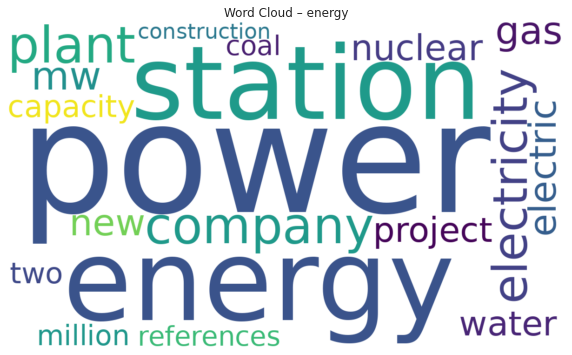

  Saved: /dbfs/FileStore/wordclouds/wordcloud_energy.png


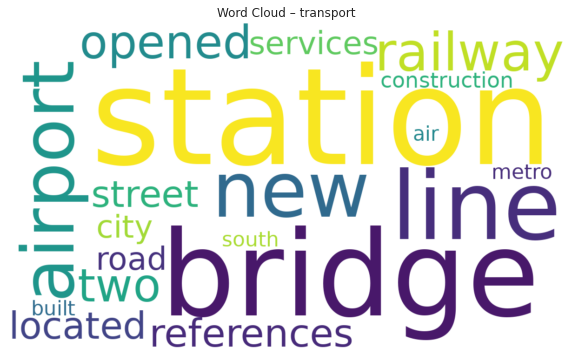

  Saved: /dbfs/FileStore/wordclouds/wordcloud_transport.png


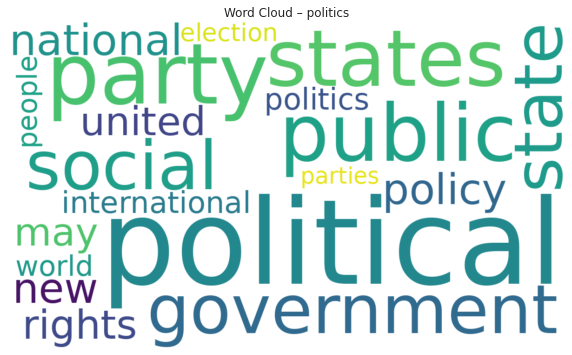

  Saved: /dbfs/FileStore/wordclouds/wordcloud_politics.png


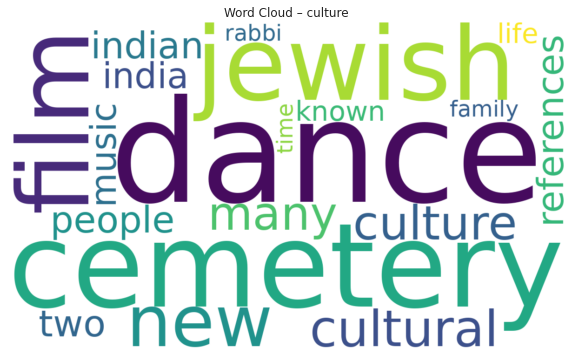

  Saved: /dbfs/FileStore/wordclouds/wordcloud_culture.png


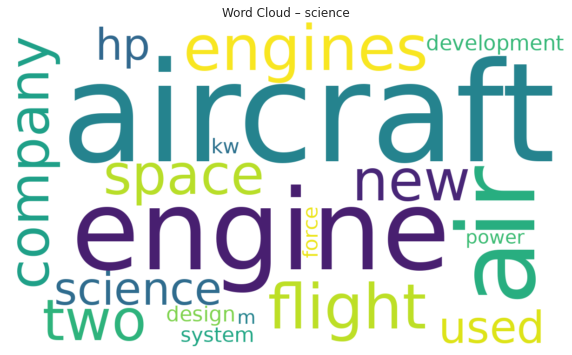

  Saved: /dbfs/FileStore/wordclouds/wordcloud_science.png


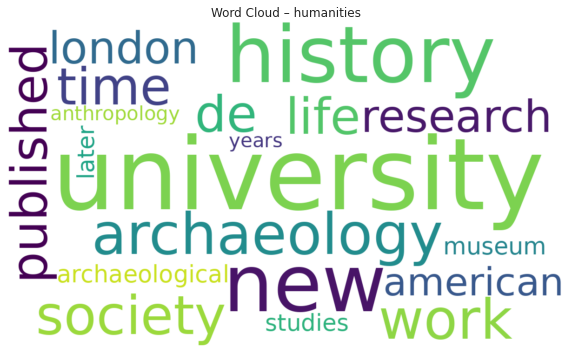

  Saved: /dbfs/FileStore/wordclouds/wordcloud_humanities.png


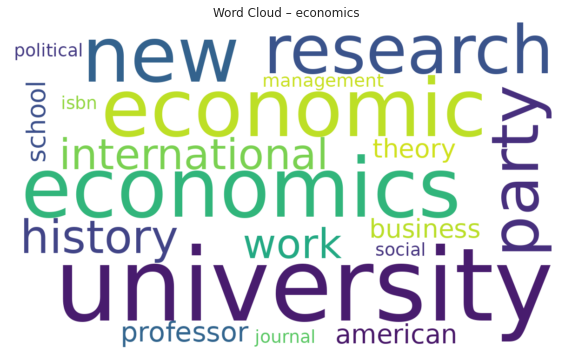

  Saved: /dbfs/FileStore/wordclouds/wordcloud_economics.png


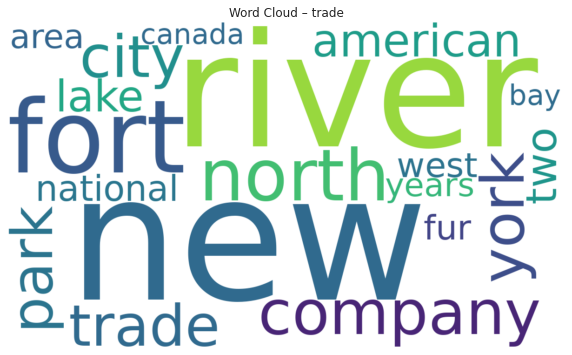

  Saved: /dbfs/FileStore/wordclouds/wordcloud_trade.png


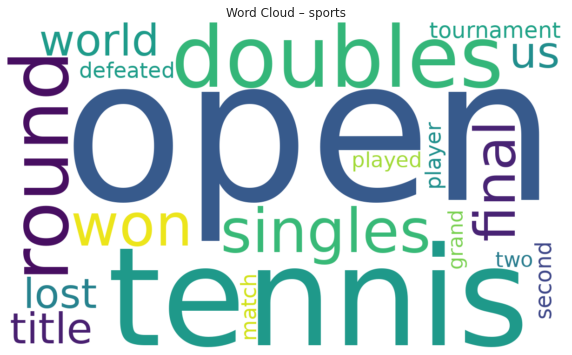

  Saved: /dbfs/FileStore/wordclouds/wordcloud_sports.png


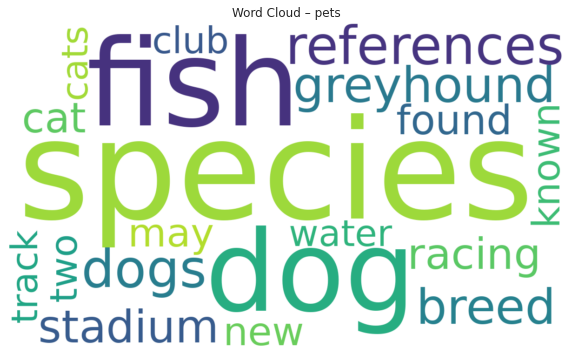

  Saved: /dbfs/FileStore/wordclouds/wordcloud_pets.png


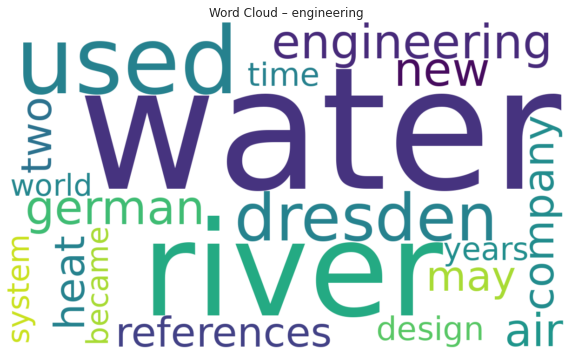

  Saved: /dbfs/FileStore/wordclouds/wordcloud_engineering.png


In [ ]:
df_words = df.withColumn('words', F.split(cleaned_doc, ' '))

stopwords = StopWordsRemover.loadDefaultStopWords('english')
custom_stopwords = stopwords + ['also', 'first', 'one']

remover = StopWordsRemover(
    inputCol='words',
    outputCol='filtered_words',
    stopWords=custom_stopwords
)
df_filtered = remover.transform(df_words)

df_exploded = df_filtered.withColumn('word', F.explode(df_filtered['filtered_words']))

word_counts = df_exploded.groupBy('category', 'word').count()

categories = word_counts.select('category').distinct().collect()

top_n = 20

for category in categories:
    category_name = category['category']
    print(f"\nCategoria: {category_name}")
    category_words = (word_counts
                      .filter(word_counts['category'] == category_name)
                      .orderBy(F.desc('count'))
                      .limit(top_n))
    for row in category_words.collect():
        print(f"{row['word']}: {row['count']}")


import os
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud


FONT_PATH = os.path.join(matplotlib.get_data_path(), "fonts", "ttf", "DejaVuSans.ttf")


save_dir = "/dbfs/FileStore/wordclouds"
os.makedirs(save_dir, exist_ok=True)

for category in categories:
    category_name = category['category']

    rows = (word_counts
            .filter(word_counts['category'] == category_name)
            .orderBy(F.desc('count'))
            .limit(top_n)
            .collect())

    freqs = {r['word']: r['count'] for r in rows if r['word']}
    if not freqs:
        print(f"Categoria: {category_name} (nessuna parola)")
        continue

    wc = WordCloud(
        width=1200, height=700,
        background_color="white",
        collocations=False,
        font_path=FONT_PATH
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(10,6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud – {category_name}")
    plt.show()


    safe_name = "".join(c if c.isalnum() or c in "-_." else "_" for c in str(category_name))
    out_path = os.path.join(save_dir, f"wordcloud_{safe_name}.png")
    wc.to_file(out_path)
    print("  Saved:", out_path)

**4. AUTOMATIC CLASSIFIER**

In [ ]:
models = {'Logistic Regression': LogisticRegression(labelCol='label', featuresCol='features'),
          'Complement Naive Bayes': NaiveBayes(labelCol='label', featuresCol='features', modelType='complement'),
          'Random Forest': RandomForestClassifier(labelCol='label', featuresCol='features')}

In [ ]:
print(f'Number of rows before removal: {df.count()}')
print(f'Number of rows with same text and different category: {duplicates_text.agg({"count": "sum"}).collect()[0][0]}')

df = df.join(duplicates_text, on=['summary', 'documents'], how="left_anti")

print(f'Number of rows after removal: {df.count()}')

Number of rows before removal: 74574
Number of rows with same text and different category: 2396
Number of rows after removal: 72178


In [ ]:
category_counts = df.groupBy('category').count().orderBy('count', ascending=False)
category_percentages = category_counts['count']*100/df.count()
category_counts_perc = category_counts.withColumn('percentage',
                                                  F.round(category_percentages, 2))
display(category_counts_perc)

category count percentage transport 7820 10.83 medicine 7504 10.4 research 6813 9.44 technology 6605 9.15 engineering 5988 8.3 humanities 5731 7.94 finance 5143 7.13 pets 4603 6.38 energy 4437 6.15 economics 4208 5.83 trade 3815 5.29 sports 3607 5.0 science 3549 4.92 culture 2122 2.94 politics 233 0.32

Now the category with the most items in it is no longer medicine but transport.

In [ ]:
lemmatizer = WordNetLemmatizer()

@pandas_udf(ArrayType(StringType()))

def lemmatize_udf(tokens: pd.Series) -> pd.Series:

    """
    Lemmatizes tokenized text data in a Pandas Series.

    This function takes a Pandas Series where each element is a list of tokens,
    and lemmatizes each token using NLTK's WordNetLemmatizer.

    Args:
        tokens (pd.Series): A Pandas Series where each element is a list of strings (tokens) to be lemmatized.

    Returns:
        pd.Series: A Pandas Series where each element is a list of lemmatized tokens.
    """

    return tokens.apply(lambda token_list: [lemmatizer.lemmatize(token) for token in token_list])

In [ ]:
def text_cleaner(df, input_col, output_col):

    """
    Cleans the text data in the specified column by performing several preprocessing steps:
    1. Converts text to lowercase and removes non-alphabetical characters.
    2. Tokenizes the text.
    3. Removes stopwords from the tokenized text.
    4. Lemmatizes the filtered tokens.

    Args:
        df (DataFrame): The input PySpark DataFrame containing the text data.
        input_col (str): The name of the column containing the raw text to be cleaned.
        output_col (str): The name of the column to store the trasformed output.

    Returns:
        DataFrame: A PySpark DataFrame with the added trasformed column.
    """

    df = df.withColumn(f'{input_col}_clean', F.regexp_replace(F.lower(col(input_col)), r'[^a-zA-Z\s]', ''))

    tokenizer = Tokenizer(inputCol=f'{input_col}_clean', outputCol=f'{input_col}_tokens')
    df_tokenized = tokenizer.transform(df)

    remover = StopWordsRemover(inputCol=f'{input_col}_tokens', outputCol=f'{input_col}_filtered')
    df_filtered = remover.transform(df_tokenized)

    df_lemmatized = df_filtered.withColumn(output_col, lemmatize_udf(f'{input_col}_filtered'))

    return df_lemmatized

In [ ]:
df = text_cleaner(df, input_col='summary', output_col='summary_cleaned')
df = text_cleaner(df, input_col='documents', output_col='documents_cleaned')

display(df.select('summary', 'summary_cleaned', 'documents', 'documents_cleaned').limit(5))

summary summary_cleaned documents documents_cleaned "(i'll never be) maria magdalena", also known simply as "maria magdalena", is a song recorded by german singer sandra for her debut studio album the long play (1985). the song, written by hubert kemmler, markus löhr, michael cretu and richard palmer-james, was released as the lead single from the long play on 15 july 1985 by virgin records, and was a major chart hit in europe, reaching number one in multiple countries. it remains sandra's signature song. List(ill, never, maria, magdalena, also, known, simply, maria, magdalena, song, recorded, german, singer, sandra, debut, studio, album, long, play, , song, written, hubert, kemmler, markus, lhr, michael, cretu, richard, palmerjames, released, lead, single, long, play, , july, , virgin, record, major, chart, hit, europe, reaching, number, one, multiple, country, remains, sandras, signature, song) "(i'll never be) maria magdalena", also known simply as "maria magdalena", is a song recorded by german singer sandra for her debut studio album the long play (1985). the song, written by hubert kemmler, markus löhr, michael cretu and richard palmer-james, was released as the lead single from the long play on 15 july 1985 by virgin records, and was a major chart hit in europe, reaching number one in multiple countries. it remains sandra's signature song. background and release the song was composed by hubert kemmler, markus löhr and michael cretu. cretu also arranged and produced the song. the lyrics were written by richard palmer-james. the allusion to the biblical figure mary magdalene was kemmler's idea and came up when a name with seven syllables was needed for the chorus. only the german version of the name would suffice, though, "mary magdalene" has five. kemmler also provided co-lead vocals on this recording and a number of sandra's subsequent songs. the song was first released in march 1985 as the lead single from sandra's debut album the long play. it was her third single as a solo artist, but the first solo single to be released internationally. initially unsuccessful in its bid to gain radio play, the label targeted djs in greece and their tourist audiences next, and the song subsequently became a big hit in greece, where it topped the singles chart. returning tourists requested the song at home, and it eventually reached number one on the official german singles chart for four consecutive weeks between 13 september and 4 october 1985. the single then peaked at number one in austria, switzerland, sweden, norway, the netherlands and finland. it also reached number 1 on the airplay chart in germany as well as the top 5 in austria. in the pan-european charts, it was a top 10 and a top 20 hit on the airplay and sales charts, respectively.the song was re-released in a remixed version as a standalone single in 1993, but was not commercially successful, though it reached the top ten in finland and the top twenty in denmark. music website allmusic retrospectively rated it 2.5 out of 5 stars. in 1999, another remix of the song was released only in france as a promotional single in support of her compilation album my favourites. the track was remixed again for her remix album reflections (2006), and the original version was later sampled in the song "kings & queens" on her tenth album stay in touch (2012). music videos a simple performance music video was filmed in 1985, which presents sandra accompanied by a bassist/backing vocalist, a percussionist and a keyboardist. it was directed by mike leckebusch. the music video was released on sandra's vhs video compilations ten on one (the singles) and 18 greatest hits, released in 1987 and 1992, respectively, as well as the 2003 dvd the complete history.the industrial style video for the 1993 version was directed by marcus adams, and was also released on the complete history dvd. track listing and formats 7-inch vinyl singlea. "(i'll never be) maria magdalena" – 3:58 b. "party games" (inst

In [ ]:
indexer = StringIndexer(inputCol='category', outputCol='label')
df = indexer.fit(df).transform(df)
df = df.withColumn('label', F.col('label').cast('int'))

display(df.select('category', 'label').distinct().orderBy('label', ascending=True))

category label transport 0 medicine 1 research 2 technology 3 engineering 4 humanities 5 finance 6 pets 7 energy 8 economics 9 trade 10 sports 11 science 12 culture 13 politics 14

Each category has been assigned a numerical label. They are sorted by the number of items they contain, in descending order.

In [ ]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

train_count = train_df.count()
test_count = test_df.count()

display(train_df.select('summary_cleaned', 'documents_cleaned', 'label').limit(5))
print(f"Train set number of samples: {train_count}")

display(test_df.select('summary_cleaned', 'documents_cleaned', 'label').limit(5))
print(f"Test set number of samples: {test_count}")

summary_cleaned documents_cleaned label List(ill, never, maria, magdalena, also, known, simply, maria, magdalena, song, recorded, german, singer, sandra, debut, studio, album, long, play, , song, written, hubert, kemmler, markus, lhr, michael, cretu, richard, palmerjames, released, lead, single, long, play, , july, , virgin, record, major, chart, hit, europe, reaching, number, one, multiple, country, remains, sandras, signature, song) List(ill, never, maria, magdalena, also, known, simply, maria, magdalena, song, recorded, german, singer, sandra, debut, studio, album, long, play, , song, written, hubert, kemmler, markus, lhr, michael, cretu, richard, palmerjames, released, lead, single, long, play, , july, , virgin, record, major, chart, hit, europe, reaching, number, one, multiple, country, remains, sandras, signature, song, background, release, song, composed, hubert, kemmler, markus, lhr, michael, cretu, cretu, also, arranged, produced, song, lyric, written, richard, palmerjames, allusion, biblical, figure, mary, magdalene, kemmlers, idea, came, name, seven, syllable, needed, chorus, german, version, name, suffice, though, mary, magdalene, five, kemmler, also, provided, colead, vocal, recording, number, sandras, subsequent, song, song, first, released, march, , lead, single, sandras, debut, album, long, play, third, single, solo, artist, first, solo, single, released, internationally, initially, unsuccessful, bid, gain, radio, play, label, targeted, dj, greece, tourist, audience, next, song, subsequently, became, big, hit, greece, topped, single, chart, returning, tourist, requested, song, home, eventually, reached, number, one, official, german, single, chart, four, consecutive, week, , september, , october, , single, peaked, number, one, austria, switzerland, sweden, norway, netherlands, finland, also, reached, number, , airplay, chart, germany, well, top, , austria, paneuropean, chart, top, , top, , hit, airplay, sale, chart, respectivelythe, song, rereleased, remixed, version, standalone, single, , commercially, successful, though, reached, top, ten, finland, top, twenty, denmark, music, website, allmusic, retrospectively, rated, , , star, , another, remix, song, released, france, promotional, single, support, compilation, album, favourite, track, remixed, remix, album, reflection, , original, version, later, sampled, song, king, , queen, tenth, album, stay, touch, , music, video, simple, performance, music, video, filmed, , present, sandra, accompanied, bassistbacking, vocalist, percussionist, keyboardist, directed, mike, leckebusch, music, video, released, sandras, vhs, video, compilation, ten, one, single, , greatest, hit, released, , , respectively, well, , dvd, complete, historythe, industrial, style, video, , version, directed, marcus, adam, also, released, complete, history, dvd, track, listing, format, inch, vinyl, singlea, ill, never, maria, magdalena, , , b, party, game, instrumental, , inch, vinyl, singlea, ill, never, maria, magdalena, , , b, party, game, instrumental, , cd, maxisingle, maria, magdalena, radio, edit, , , maria, magdalena, clubmix, , , maria, magdalena, original, version, , inch, vinyl, single, maria, magdalena, clubmix, , , b, maria, magdalena, vega, sicilia, mix, , inch, vinyl, single, maria, magdalena, original, version, , , b, maria, magdalena, , remix, , , chart, certification, sampling, , background, music, song, ill, never, maria, magdalena, used, song, vino, noi, performed, croatian, singer, neno, belan, lead, vocalist, band, avoli, reference, external, link, ill, never, maria, magdalena, discogs, official, sandra, youtube, channel) 1 List(kidnapped, santa, claus, christmasthemed, short, story, american, writer, l, frank, baum, called, one, baum, beautiful, story, constitutes, influential, contribution, mythology, christmas, kidnapped, santa, claus, first, published, december, , edition, delineator, womens, magazine, print, baum, animal, fairy, tale, following, year, magazine, text, a

Train set number of samples: 57997


summary_cleaned documents_cleaned label List(untold, story, twentythird, episode, fifth, season, american, fantasy, drama, series, upon, time, aired, may, , , episode, served, part, , part, fifthseason, finale, first, part, episode, henry, violet, emma, regina, mr, gold, work, together, bring, snow, david, hook, zelena, back, land, untold, story, near, end, regina, take, evil, queen, mr, hyde, arrives, storybrooke) List(untold, story, twentythird, episode, fifth, season, american, fantasy, drama, series, upon, time, aired, may, , , episode, served, part, , part, fifthseason, finale, first, part, episode, henry, violet, emma, regina, mr, gold, work, together, bring, snow, david, hook, zelena, back, land, untold, story, near, end, regina, take, evil, queen, mr, hyde, arrives, storybrooke, plot, opening, sequence, special, element, featured, title, card, original, airing, title, logo, attached, flying, dirigible, later, release, event, chronology, land, untold, story, land, without, magic, storybrooke, event, take, place, savior, land, untold, story, dr, jekyll, awakens, straitjacket, finding, poole, unconscious, much, whisky, freeing, take, pooles, key, hyde, hidden, wand, freeing, zelena, hook, snow, david, explains, warden, stole, zelenas, wand, find, land, untold, story, filled, escapee, various, world, seeking, refuge, realm, story, halted, time, pas, dr, jekyll, finished, blue, serum, flower, sap, turned, red, serum, separate, evil, good, person, however, poole, enters, force, transform, mr, hyde, using, blue, serum, hero, flee, per, jekylls, request, escape, mr, hyde, injects, red, serum, splitting, dr, jekyll, apart, hyde, try, kill, jekyll, hook, others, rescue, jekyll, zelena, us, fireball, poole, snow, us, pooles, magical, gizmo, zap, hyde, unconscious, jekyll, take, serum, tool, hyde, wake, group, keep, trying, escape, realm, end, ultimately, running, dead, end, every, turn, suddenly, thanks, henry, inspiring, new, yorkers, toss, coin, bethesda, fountain, portal, open, hook, snow, david, zelena, jekyll, escape, find, new, york, city, right, front, fountain, reunite, emma, regina, henry, violet, later, hyde, begin, throwing, tantrum, laboratory, surprised, see, gold, slipped, portal, find, belle, gold, want, threaten, hyde, death, let, live, upon, learning, hyde, know, wake, belle, without, true, love, kiss, result, deal, made, gold, hyde, new, york, city, hotel, gold, swipe, sterling, silver, tray, concierge, give, , left, alone, emma, learns, via, text, zelena, hook, others, disappeared, regina, go, right, gold, hotel, room, tell, may, turning, darkness, emma, try, snag, olympian, crystal, gold, distracted, scheme, chase, henry, enters, holy, grail, drain, crystal, magic, angry, gold, scold, henry, accidentally, preventing, family, coming, home, gold, concede, storybrooke, never, danger, magic, brought, lied, motivate, emma, regina, finding, henry, henry, sulk, bethesda, fountain, violet, gold, take, regina, find, someone, claim, still, magic, emma, reminds, henry, time, new, york, telling, still, wish, away, problem, toss, coin, fountain, reflects, irony, word, wished, fill, void, felt, family, lead, hook, showing, memory, potion, elsewhere, gold, lead, regina, shop, meet, dragon, survived, tamaras, attack, though, refuse, help, gold, dragon, agrees, help, regina, emma, henry, violet, gold, regina, watch, dragon, create, small, view, family, however, fails, open, portal, magic, enough, tell, despite, called, land, without, magic, exist, real, world, however, become, harder, tap, neglect, realizing, dragon, mean, henry, lead, everyone, back, fountain, proceeds, wish, family, brought, back, encouraging, emma, regina, gold, violet, causing, crystal, pulsate, henry, convinces, citizen, help, return, magic, world, portal, open, fountain, gold, walk, hook, snow, david, jekyll, zelena, return, via, portal, reuniting, rest, group, henry, left, saddened, crowd, believed, rescue, illusion, emma, console, explaining, way, unde

Test set number of samples: 14181


The training set consists of 57,997 samples and the test set of 14,181 samples.

**5. FINAL MODEL**


The project implements a complete text-classification workflow on Spark/Databricks (6 phases: class-weighting, caching/checkpointing, evaluation utilities, multi-model training, model comparison, and LR hyper-parameter tuning).
However, due to the memory limits of Databricks Free, full execution on the entire dataset is not feasible.

Following the instructor’s guidance, I added an alternative final model that is fully executable:

1. Early small random sample from raw data (before any transformation): sampled directly from the raw CSV (/databricks/driver/wikipedia.csv), using a fixed seed and keeping only classes with a minimum number of samples to ensure at least two classes.

2. Lightweight in-memory model (scikit-learn): TF-IDF (1–2 n-grams, min_df=3, max_df=0.9, sublinear_tf=True) → LinearSVC with balanced class weights.

3. Reproducible evaluation: 80/10/10 train/validation/test split with stratification; reported Accuracy, Macro/Micro/Weighted-F1 and a confusion matrix.

4. Artifacts: saved the final pipeline and label encoder for verification.

This path meets the requirement of “taking a small sample before any operation” and “building an equivalent scikit-learn model,” while keeping the original Spark pipeline for methodological completeness.

To comply with the instructor’s request and ensure executability on Databricks Free, the final model below uses a small random sample taken directly from the raw CSV (before any Spark transformation) and trains an equivalent scikit-learn pipeline (TF-IDF + LinearSVC). We report Accuracy, Macro/Micro/Weighted-F1, and a confusion matrix, and save the model artifacts for verification.

In [ ]:
import pandas as pd, numpy as np, re, os

SEED    = 42
RAW_PATH = "/databricks/driver/wikipedia.csv"
TARGET  = 8000


with open(RAW_PATH, "r", encoding="utf-8", errors="ignore") as f:
    n_total = sum(1 for _ in f) - 1

rng = np.random.default_rng(SEED)
frac = min(1.0, TARGET / max(1, n_total))


df = pd.read_csv(RAW_PATH, skiprows=lambda i: i>0 and rng.random() > frac)


for junk in ["Unnamed: 0", "index"]:
    if junk in df.columns:
        df = df.drop(columns=[junk])
if "category" not in df.columns and "categoria" in df.columns:
    df = df.rename(columns={"categoria": "category"})


def clean(s):
    s = (str(s) if pd.notna(s) else "").lower()
    s = re.sub(r"[^a-z0-9àèéìòóùç\s]", " ", s)
    return re.sub(r"\s+"," ", s).strip()

df["text"] = (df["summary"].fillna("") + " " + df["documents"].fillna("")).map(clean)
df = df[(df["text"].str.len()>0)].drop_duplicates(subset=["text","category"]).reset_index(drop=True)
print("Sample:", df.shape, "— categories:", df["category"].nunique())

Sample: (6745, 5) — categories: 15


In [ ]:
vc = df["category"].value_counts()
keep = vc[vc >= 3].index
df = df[df["category"].isin(keep)].reset_index(drop=True)

n_cls = df["category"].nunique()
print("Classes after Filter:", n_cls)
assert n_cls >= 2, "Ancora 1 classe: alza TARGET (es. 15000) e riesegui Cella 1*"

Classes after Filter: 15


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df["label"] = le.fit_transform(df["category"].astype(str))

X = df["text"].values
y = df["label"].values

X_tr, X_tmp, y_tr, y_tmp = train_test_split(X, y, test_size=0.20, random_state=SEED, stratify=y)
X_val, X_te,  y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp)

len(X_tr), len(X_val), len(X_te)

Out[38]: (5396, 674, 675)

VAL  Acc: 0.8947 | Macro-F1: 0.8824
TEST Acc: 0.9081
TEST Macro-F1: 0.9132 | Micro-F1: 0.9081 | Weighted-F1: 0.9078

Report per classe:
              precision    recall  f1-score   support

     culture       0.92      0.95      0.94        38
   economics       0.92      0.96      0.94        49
      energy       0.98      0.98      0.98        53
 engineering       0.95      0.86      0.90        49
     finance       0.82      0.82      0.82        44
  humanities       0.86      0.96      0.91        52
    medicine       0.88      0.75      0.81        51
        pets       0.96      0.96      0.96        49
    politics       1.00      1.00      1.00         5
    research       0.76      0.82      0.79        51
     science       0.92      0.87      0.89        39
      sports       0.94      0.96      0.95        47
  technology       0.89      0.94      0.91        50
       trade       0.98      0.91      0.94        46
   transport       0.94      0.96      0.95        52

<command-4219203551701442>:38: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.figure.colorbar(im, ax=ax)


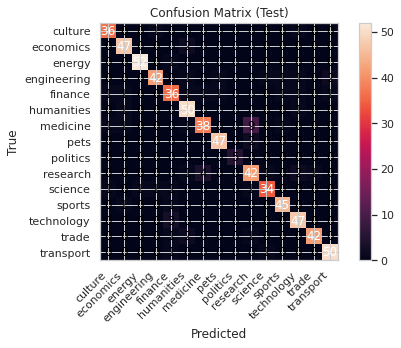

Artefatti salvati in: /dbfs/FileStore/wikipedia_artifacts


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np, matplotlib.pyplot as plt, itertools, os, joblib


classes = np.unique(y_tr)
cw = compute_class_weight("balanced", classes=classes, y=y_tr)
weights = {int(c): float(w) for c,w in zip(classes, cw)}

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)),
    ("clf", LinearSVC(class_weight=weights, random_state=SEED))
])


pipe.fit(X_tr, y_tr)
p_val = pipe.predict(X_val)
print("VAL  Acc:", round(accuracy_score(y_val, p_val), 4),
      "| Macro-F1:", round(f1_score(y_val, p_val, average="macro"), 4))


pipe.fit(np.concatenate([X_tr, X_val]), np.concatenate([y_tr, y_val]))
p_te = pipe.predict(X_te)
print("TEST Acc:", round(accuracy_score(y_te, p_te), 4))
print("TEST Macro-F1:", round(f1_score(y_te, p_te, average="macro"), 4),
      "| Micro-F1:", round(f1_score(y_te, p_te, average="micro"), 4),
      "| Weighted-F1:", round(f1_score(y_te, p_te, average="weighted"), 4))
print("\nReport per classe:")
print(classification_report(y_te, p_te, target_names=le.classes_))


cm = confusion_matrix(y_te, p_te)
fig, ax = plt.subplots(figsize=(7,5))
im = ax.imshow(cm, interpolation="nearest")
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=range(len(le.classes_)), yticks=range(len(le.classes_)),
       xticklabels=le.classes_, yticklabels=le.classes_,
       xlabel="Predicted", ylabel="True", title="Confusion Matrix (Test)")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
thr = cm.max()/2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i,j]), ha="center", va="center",
                color="white" if cm[i,j]>thr else "black")
plt.tight_layout()
plt.show()


save_dir = "/dbfs/FileStore/wikipedia_artifacts" if os.path.exists("/dbfs") else "./artifacts"
os.makedirs(save_dir, exist_ok=True)
joblib.dump(pipe, os.path.join(save_dir, "final_text_classifier.joblib"))
joblib.dump(le,   os.path.join(save_dir, "label_encoder.joblib"))
print("Artefatti salvati in:", save_dir)

The confusion matrix highlights the overall robustness of the classification pipeline, as reflected in consistent accuracy and balanced F1-scores across most categories. Nonetheless, certain classes exhibit higher misclassification rates, which may be attributed to semantic similarity among categories or to data imbalance within the training set. This outcome indicates that while the proposed approach provides a solid baseline, further refinements — such as dataset augmentation, advanced feature engineering, or the adoption of more sophisticated learning architectures — could enhance model generalization and reduce class-specific errors.
